**Research Question 1 (Regression):** Can we accurately predict a driver's fastest lap time using only *pre-race* data?
- **Methods:** Ridge Regression and LASSO (to handle multicollinearity).
- **Goal:** Identify the most critical pre-race factors (e.g., qualifying performance, grid position) while avoiding "data leakage" (using post-race data like average lap time).

Import and Loading of the Data

In [202]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
from scipy.stats import wilcoxon
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.style.use("classic")
sns.set_context("paper", font_scale=1.3)

filepath = glob.glob('f1datasets/*.csv') # 14 datasets
f1_dfs = {}
for file in filepath:
    filename = os.path.basename(file)
    df_name = os.path.splitext(filename)[0]
    f1_dfs[df_name] = pd.read_csv(file)
print("Datasets loaded.")

rand_st = 7604 # random state for reproducibility

cv5 = KFold(n_splits=5, shuffle=True, random_state=rand_st) # 5-fold cross-validation

Datasets loaded.


**Cleaning the data // Feature Engineering `(driver_age_at_race)`**

In [203]:
for df_name in f1_dfs:
    f1_dfs[df_name].replace(r'\\N', np.nan, inplace=True)
print("Missing values replaced.")

def time_to_ms(time_str): # converts time strings to milliseconds
    if pd.isna(time_str): 
        return np.nan
    parts = str(time_str).split(':')
    try: 
        if len(parts) == 2: # M:SS.mmm
            return int((int(parts[0]) * 60 + float(parts[1])) * 1000)
        elif len(parts) == 3: # H:MM:SS.mmm
            return int((int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])) * 1000)
        else: return np.nan
    except ValueError: 
        return np.nan

# Clean 'results' (Response Variables)
df_results = f1_dfs['results'].copy()
df_results['fastestLapTime_ms'] = df_results['fastestLapTime'].apply(time_to_ms)
df_results['positionOrder'] = pd.to_numeric(df_results['positionOrder'], errors='coerce')
df_results['grid'] = pd.to_numeric(df_results['grid'], errors='coerce')

# Clean 'qualifying' (Predictors)
df_quali = f1_dfs['qualifying'].copy()
for col in ['q1', 'q2', 'q3']:
    df_quali[f'{col}_ms'] = df_quali[col].apply(time_to_ms)
df_quali_short = df_quali[['raceId', 'driverId', 'constructorId', 'position', 'q1_ms', 'q2_ms', 
                           'q3_ms']].rename(columns={'position': 'qualifying_position'})

# Clean 'races' & 'drivers' (Context)
df_races = f1_dfs['races'].copy()
df_races['date'] = pd.to_datetime(df_races['date'])
df_races_short = df_races[['raceId', 'year', 'round', 'circuitId', 'date']]

df_drivers = f1_dfs['drivers'].copy()
df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
df_drivers_short = df_drivers[['driverId', 'driverRef', 'nationality', 'dob']]

# Merge into Master DataFrame
master_f1 = pd.merge(df_results, df_races_short, on='raceId', how='left')
master_f1 = pd.merge(master_f1, df_quali_short, on=['raceId', 'driverId', 'constructorId'], how='left')
master_f1 = pd.merge(master_f1, df_drivers_short, on='driverId', how='left')

# Feature Engineering and Polynomial Terms: Age and Age Squared
master_f1['driver_age_at_race'] = (master_f1['date'] - master_f1['dob']).dt.days / 365.25 # age in years
master_f1['driver_age_sq'] = master_f1['driver_age_at_race'] ** 2 # age squared for non-linear effects

print("Master DataFrame created.")
master_f1.head()

Missing values replaced.
Master DataFrame created.


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,date,qualifying_position,q1_ms,q2_ms,q3_ms,driverRef,nationality,dob,driver_age_at_race,driver_age_sq
0,1,18,1,1,22,1,1,1,1,10.0,...,2008-03-16,1.0,86572.0,85187.0,86714.0,hamilton,British,1985-01-07,23.186858,537.630399
1,2,18,2,2,3,5,2,2,2,8.0,...,2008-03-16,5.0,85960.0,85518.0,87236.0,heidfeld,German,1977-05-10,30.850103,951.728835
2,3,18,3,3,7,7,3,3,3,6.0,...,2008-03-16,7.0,86295.0,86059.0,88687.0,rosberg,German,1985-06-27,22.718686,516.138686
3,4,18,4,4,5,11,4,4,4,5.0,...,2008-03-16,12.0,86907.0,86188.0,NaN,alonso,Spanish,1981-07-29,26.631075,709.214135
4,5,18,5,1,23,3,5,5,5,4.0,...,2008-03-16,3.0,85664.0,85452.0,87079.0,kovalainen,Finnish,1981-10-19,26.406571,697.306984


**Prepping and Splitting // Target Encoding `'circuitId'` --> `'circuit_difficulty'`**

In [204]:
# Feature Engineering Teammate Delta
constructor_means = master_f1.groupby(['year', 'raceId', 'constructorId'])['q1_ms'].transform('mean')
master_f1['teammate_q1_delta'] = master_f1['q1_ms'] - constructor_means

# Selecting only pre-race predictors
X_cols = ['year', 'circuitId', 'grid', 'qualifying_position', 'q1_ms', 'q2_ms', 'q3_ms', 
          'driver_age_at_race', 'driver_age_sq', 'teammate_q1_delta']
X = master_f1[X_cols].copy()
y1 = master_f1['fastestLapTime_ms']
y_position = master_f1['positionOrder']

# Dropping rows with missing target values
mask = y1.notna()
X = X[mask]
y1 = y1[mask]
y_position = y_position[mask]

# Impute missing values in predictors
# Mean imputation would be skewed by outliers, so we use median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Train-Test Split: 80-20
X_train_idx, X_test_idx= train_test_split(X_imputed.index, test_size=0.2, random_state=rand_st)

# Final Train/Test Sets
X_train = X_imputed.loc[X_train_idx].copy()
X_test = X_imputed.loc[X_test_idx].copy()
y1_train = y1.loc[X_train_idx]
y1_test = y1.loc[X_test_idx]
y_pos_train = y_position.loc[X_train_idx] # required for target encoding

# Target encoding for 'circuitId' as it is categorical with many levels
circuit_means = y1_train.groupby(X_train['circuitId']).mean() # mean fastest lap time per circuit
X_train['circuit_difficulty'] = X_train['circuitId'].map(circuit_means)
X_test['circuit_difficulty'] = X_test['circuitId'].map(circuit_means) # map using train set means
# Imputing missing values in test set encoding with global mean
X_test['circuit_difficulty'].fillna(y1_train.mean(), inplace=True)
# Dropping original 'circuitId' column
X_train.drop(columns=['circuitId'], inplace=True)
X_test.drop(columns=['circuitId'], inplace=True)

# Update X_cols
X_cols = X_train.columns.tolist()

print("'circuitId' target encoded. Replaced with 'circuit_difficulty'.")

# Scaling for distance-based models (i.e. Ridge, LASSO, PCA, PLS)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data preprocessing complete.")

'circuitId' target encoded. Replaced with 'circuit_difficulty'.
Data preprocessing complete.


C:\Users\couga\AppData\Local\Temp\ipykernel_21308\4140060421.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['circuit_difficulty'].fillna(y1_train.mean(), inplace=True)


In [205]:
X_train.head()

,year,grid,qualifying_position,q1_ms,q2_ms,q3_ms,driver_age_at_race,driver_age_sq,teammate_q1_delta,circuit_difficulty
1466,2005.0,17.0,8.0,73041.0,87200.0,87066.0,31.203285,973.645021,-122.0,76056.393189
25229,2021.0,12.0,14.0,81500.0,81103.0,87066.0,24.985626,624.281521,6.5,86090.566372
23198,2016.0,2.0,2.0,82497.0,81809.0,81613.0,31.189596,972.790909,321.5,86090.566372
20802,2011.0,7.0,7.0,96744.0,96557.0,96251.0,29.957563,897.455600,-76.0,100296.840517
1214,2005.0,19.0,19.0,86484.0,90564.0,87066.0,24.574949,603.928102,282.0,81900.898148


**Model Training**

In [206]:
# RidgeCV
alphas = np.logspace(-1, 2, 100) # 0.1 to 100
ridge_model = RidgeCV(alphas=alphas, cv=cv5).fit(X_train_scaled, y1_train)
print("RidgeCV model trained.")
print(f"Ridge Alpha: {ridge_model.alpha_}")

# LassoCV
lasso_model = LassoCV(cv=cv5, random_state=rand_st).fit(X_train_scaled, y1_train) # finds the optimal alpha automatically
print("\nLassoCV model trained.")
print(f"Lasso Alpha: {lasso_model.alpha_}")

# Evaluation using R^2 score
r2_ridge = r2_score(y1_test, ridge_model.predict(X_test_scaled))
r2_lasso = r2_score(y1_test, lasso_model.predict(X_test_scaled))
print(f"\nRidge R^2 on Test Set: {r2_ridge:.4f}")
print(f"Lasso R^2 on Test Set: {r2_lasso:.4f}")

# Feature Importance
coefs = pd.DataFrame({
    'Feature': X_cols,
    'Coef': lasso_model.coef_,
    'AbsCoef': np.abs(lasso_model.coef_)
}).sort_values(by='AbsCoef', ascending=False)

print("\nLASSO Feature Importances:")
print(coefs[['Feature', 'Coef']])

RidgeCV model trained.
Ridge Alpha: 16.297508346206453

LassoCV model trained.
Lasso Alpha: 10.969632567651868

Ridge R^2 on Test Set: 0.7909
Lasso R^2 on Test Set: 0.7909

LASSO Feature Importances:
               Feature         Coef
9   circuit_difficulty  6791.124277
3                q1_ms  4645.309264
2  qualifying_position   460.775329
1                 grid   341.953122
8    teammate_q1_delta  -264.937273
4                q2_ms   137.410468
5                q3_ms   125.474880
0                 year   107.256611
6   driver_age_at_race   -20.403354
7        driver_age_sq    -0.000000


Further Evaluation for LASSO

In [207]:
# Bootstrapping the Confidence Intervals for LASSO
n_bootstraps = 100
bootstrap_coefs = []
optimal_alpha = lasso_model.alpha_
print(f"Bootstrapping LASSO Coefficients with Alpha: {optimal_alpha:.4f} for {n_bootstraps} iterations.")

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train_scaled, y1_train, random_state=rand_st + i)
    # Fit LASSO with optimal alpha
    lasso_boot = Lasso(alpha=optimal_alpha, random_state=rand_st)
    lasso_boot.fit(X_resampled, y_resampled)
    # Store coefficients
    bootstrap_coefs.append(lasso_boot.coef_)

bootstrap_df = pd.DataFrame(bootstrap_coefs, columns=X_cols)
coef_summary = pd.DataFrame({
    'Feature': X_cols,
    'MeanCoef': bootstrap_df.mean(),
    'StdError': bootstrap_df.std(),
    'LowerCI': bootstrap_df.quantile(0.025),
    'UpperCI': bootstrap_df.quantile(0.975)
}).sort_values(by='MeanCoef', key=abs, ascending=False)

print("\nBootstrap Coefficient Summary:")
print(coef_summary.head(5)[['MeanCoef', 'StdError', 'LowerCI', 'UpperCI']])

Bootstrapping LASSO Coefficients with Alpha: 10.9696 for 100 iterations.

Bootstrap Coefficient Summary:
                        MeanCoef    StdError      LowerCI      UpperCI
circuit_difficulty   6806.892974  214.957970  6328.050182  7168.600850
q1_ms                4612.279414  245.185765  4158.817802  5045.688953
qualifying_position   448.274271  152.449755   151.050948   711.445758
grid                  356.524160  151.269177   108.566348   633.464016
teammate_q1_delta    -256.711840   74.668972  -390.636605  -119.709121


In [208]:
# Random Forest Regressor for Non-Linear Modeling
rf_reg = RandomForestRegressor(n_estimators=n_bootstraps, max_depth=10, random_state=rand_st)
rf_reg.fit(X_train_scaled, y1_train)
r2_rf = r2_score(y1_test, rf_reg.predict(X_test_scaled))

print(f"LASSO R^2 on Test Set: {r2_lasso:.4f}")
print(f"Random Forest Regressor R^2 on Test Set: {r2_rf:.4f}")
print(f"Improvement of Non-Linear Model over LASSO: {r2_rf - r2_lasso:.4f}")

LASSO R^2 on Test Set: 0.7909
Random Forest Regressor R^2 on Test Set: 0.8630
Improvement of Non-Linear Model over LASSO: 0.0721


PCR/PLS Testing and Evaluation

In [209]:
# Aligning target variable (y2) for train-test split
y2 = master_f1['positionOrder'][mask]
_, _, y2_train, y2_test = train_test_split(X_imputed, y2, test_size=0.2, random_state=rand_st)
n_comp = np.arange(1, X_train_scaled.shape[1] + 1) # 1 to number of features

# For storing CV results
pcr_scores = []
pcr_mean_mse = []
pls_scores = []
pls_mean_mse = []

for k in n_comp:
    # PCR
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X_train_scaled)
    lr = LinearRegression()
    scores_pcr = cross_val_score(lr, X_reduced, y2_train, cv=cv5, scoring='neg_mean_squared_error') # minimize MSE
    pcr_scores.append(-scores_pcr)
    pcr_mean_mse.append(-scores_pcr.mean())

    # PLS
    pls = PLSRegression(n_components=k)
    scores_pls = cross_val_score(pls, X_train_scaled, y2_train, cv=cv5, scoring='neg_mean_squared_error')
    pls_scores.append(-scores_pls)
    pls_mean_mse.append(-scores_pls.mean())

# Selecting k with lowest CV MSE
best_k_pcr = np.argmin(pcr_mean_mse) + 1
best_k_pls = np.argmin(pls_mean_mse) + 1

print(f"Optimal PCR components: {best_k_pcr} (CV MSE: {min(pcr_mean_mse):.2f})")
print(f"Optimal PLS components: {best_k_pls} (CV MSE: {min(pls_mean_mse):.2f})")

Optimal PCR components: 10 (CV MSE: 21.05)
Optimal PLS components: 10 (CV MSE: 21.05)


In [210]:
# Paired T-test between PCR and PLS
# Extracting 5 score folds for best k
best_pcr_folds = pcr_scores[best_k_pcr - 1]
best_pls_folds = pls_scores[best_k_pls - 1]

if np.allclose(best_pcr_folds, best_pls_folds): # check if scores are identical
    print("Paired T-test not applicable: \nScores are identical.")
else:
    t_stat, p_value = stats.ttest_rel(best_pcr_folds, best_pls_folds)
    print(f"Paired T-test (PCR vs PLS):")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

Paired T-test not applicable: 
Scores are identical.


In [211]:
# Linear vs Non-Linear Comparison
# RF Importance
rf_importances = pd.DataFrame({
    'Feature': X_cols,
    'Importance': rf_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

# LASSO Importance
lasso_importances = pd.DataFrame({
    'Feature': X_cols,
    'Lasso_Coef_Abs': np.abs(lasso_model.coef_)
}).sort_values(by='Lasso_Coef_Abs', ascending=False)

Further Evaluation for Q2

In [212]:
# Test set evaluation
# PCR Final Model
pca_final = PCA(n_components=best_k_pcr)
X_train_pcr = pca_final.fit_transform(X_train_scaled)
X_test_pcr = pca_final.transform(X_test_scaled)
pcr_final = LinearRegression().fit(X_train_pcr, y2_train)
pcr_test_mse = mean_squared_error(y2_test, pcr_final.predict(X_test_pcr))

# PLS Final Model
pls_final = PLSRegression(n_components=best_k_pls)
pls_final.fit(X_train_scaled, y2_train)
pls_test_mse = mean_squared_error(y2_test, pls_final.predict(X_test_scaled))

print(f"Final Test Set MSE - PCR (k={best_k_pcr}): {pcr_test_mse:.2f}")
print(f"Final Test Set MSE - PLS (k={best_k_pls}): {pls_test_mse:.2f}")

Final Test Set MSE - PCR (k=10): 19.99
Final Test Set MSE - PLS (k=10): 19.99


In [213]:
pcr_weights = np.abs(pca_final.components_[0])
pls_weights = np.abs(pls_final.x_weights_[:, 0])
comp_weights = pd.DataFrame({
    'Feature': X_cols,
    'PCR (Variance)': pcr_weights,
    'PLS (Covariance)': pls_weights,
}).melt(id_vars='Feature', var_name='Method', value_name='Weight')
print("Component Weights for PCR and PLS calculated.")
print(comp_weights.head(20).sort_values(by='Weight', ascending=False),)

Component Weights for PCR and PLS calculated.
                Feature            Method    Weight
12  qualifying_position  PLS (Covariance)  0.717564
11                 grid  PLS (Covariance)  0.678230
3                 q1_ms    PCR (Variance)  0.518987
4                 q2_ms    PCR (Variance)  0.515565
9    circuit_difficulty    PCR (Variance)  0.492275
5                 q3_ms    PCR (Variance)  0.455658
13                q1_ms  PLS (Covariance)  0.084728
16   driver_age_at_race  PLS (Covariance)  0.079279
1                  grid    PCR (Variance)  0.072314
17        driver_age_sq  PLS (Covariance)  0.070419
2   qualifying_position    PCR (Variance)  0.069798
0                  year    PCR (Variance)  0.056638
10                 year  PLS (Covariance)  0.050171
18    teammate_q1_delta  PLS (Covariance)  0.047098
14                q2_ms  PLS (Covariance)  0.032725
7         driver_age_sq    PCR (Variance)  0.026861
6    driver_age_at_race    PCR (Variance)  0.026505
15                

Q3 Model Training

In [214]:
y3 = master_f1['positionOrder'][mask].apply(lambda x: 1 if x <= 3 else 0) # Podium Finish: Top 3 = 1, Else = 0
_, _, y3_train, y3_test = train_test_split(X_imputed, y3, test_size=0.2, random_state=rand_st)
print(f"y3_train shape: {y3_train.shape}")
print(f"Podium Balance: {y3_train.mean():.1%} of training samples are podium finishes.")

# Logistic Regression for Podium Prediction
lr_clf = LogisticRegression(max_iter=1000, random_state=rand_st)
lr_clf.fit(X_train_scaled, y3_train)

# Ensemble - Random Forest Classifier
rf_params = {'n_estimators': [100, 200], 'max_depth': [5,10]}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=rand_st, class_weight='balanced'),
    rf_params, 
    cv=cv5, 
    scoring='roc_auc', 
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y3_train)
best_rf_clf = rf_grid.best_estimator_
print(f"Best RF Classifier Params: {rf_grid.best_params_}")

y3_train shape: (6601,)
Podium Balance: 14.8% of training samples are podium finishes.
Best RF Classifier Params: {'max_depth': 5, 'n_estimators': 100}


LDA and Threshold Tuning

In [215]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y3_train)

# Predictions
y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]

# LDA Evaluation
auc_lda = roc_auc_score(y3_test, y_prob_lda)
print(f"LDA AUC: {auc_lda:.4f}")

# Threshold Tuning for Random Forest
thresholds = np.arange(0.1, 1.0, 0.01) # from 0.1 to 1.0
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_prob_rf >= t).astype(int)
    f1_scores.append(f1_score(y3_test, y_pred_temp))

best_f1 = max(f1_scores)
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"Optimal RF Threshold: {best_thresh:.2f}")
print(f"Max RF F1 Score: {best_f1:.4f}")

LDA AUC: 0.9146
Optimal RF Threshold: 0.72
Max RF F1 Score: 0.6836


Wilcoxon Signed-Rank Test

In [216]:
# Wilcoxon Signed-Rank Test between PCR and PLS
diff = np.array(best_pcr_folds) - np.array(best_pls_folds)

if np.all(diff==0): # check if all differences are zero
    print("Models are identical in every fold; P-value=1.0")
else:
    w_stat, p_val_w = wilcoxon(best_pcr_folds, best_pls_folds)
    print(f"Wilcoxon W-Statistic: {w_stat:.4f}, P-value: {p_val_w:.4f}")
    if p_val_w < 0.05:
        print("Result: Statistically significant difference")
    else:
        print("Result: No significant difference")

# Shapiro-Wilk Test for Normality of Residuals, 500 residual samples
residual_samples = np.random.choice(y1_test - rf_reg.predict(X_test_scaled), size=500)
shapiro_stat, shapiro_p = stats.shapiro(residual_samples)
print(f"\nShapiro-Wilk Statistic: {shapiro_stat:.4f}, P-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Result: Residuals are normally distributed.")
else:
    print("Result: Residuals are not normal.")

Wilcoxon W-Statistic: 0.0000, P-value: 0.2500
Result: No significant difference

Shapiro-Wilk Statistic: 0.2243, P-value=0.0000
Result: Residuals are not normal.


Top Largest Prediction Errors

In [221]:
y1_pred_rf = rf_reg.predict(X_test_scaled)
residuals_rf = y1_test - y1_pred_rf

error_df = master_f1.loc[X_test.index].copy()
error_df['Predicted_FastestLapTime_ms'] = y1_pred_rf
error_df['Error_ms'] = np.abs(error_df['fastestLapTime_ms'] - error_df['Predicted_FastestLapTime_ms'])
top_worst = error_df.sort_values('Error_ms', ascending=False).head(10)
cols_to_show = ['year', 'round', 'driverRef', 'constructorId', 'fastestLapTime_ms', 'Predicted_FastestLapTime_ms', 'Error_ms']
display(top_worst[cols_to_show])

,year,round,driverRef,constructorId,fastestLapTime_ms,Predicted_FastestLapTime_ms,Error_ms
587,2007,10,liuzzi,5,202300.0,104753.871640,97546.128360
20698,2010,16,kubica,4,161378.0,95714.328763,65663.671237
21512,2012,12,maldonado,3,176180.0,113508.467024,62671.532976
20462,2010,6,button,1,134285.0,77057.497141,57227.502859
850,2006,5,coulthard,9,144500.0,93704.691230,50795.308770
20988,2011,9,kovalainen,205,130404.0,98311.044802,32092.955198
24796,2020,9,giovinazzi,51,133809.0,103653.547215,30155.452785
24794,2020,9,latifi,3,131365.0,106166.759826,25198.240174
127,2008,6,bourdais,5,101150.0,79037.418916,22112.581084
22159,2014,2,grosjean,208,106223.0,124157.346695,17934.346695


**Plotting**

C:\Users\couga\AppData\Local\Temp\ipykernel_21308\3103083261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lasso_importances, x='Lasso_Coef_Abs', y='Feature', ax=ax[0], palette='viridis')
C:\Users\couga\AppData\Local\Temp\ipykernel_21308\3103083261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances, x='Importance', y='Feature', ax=ax[1], palette='magma')


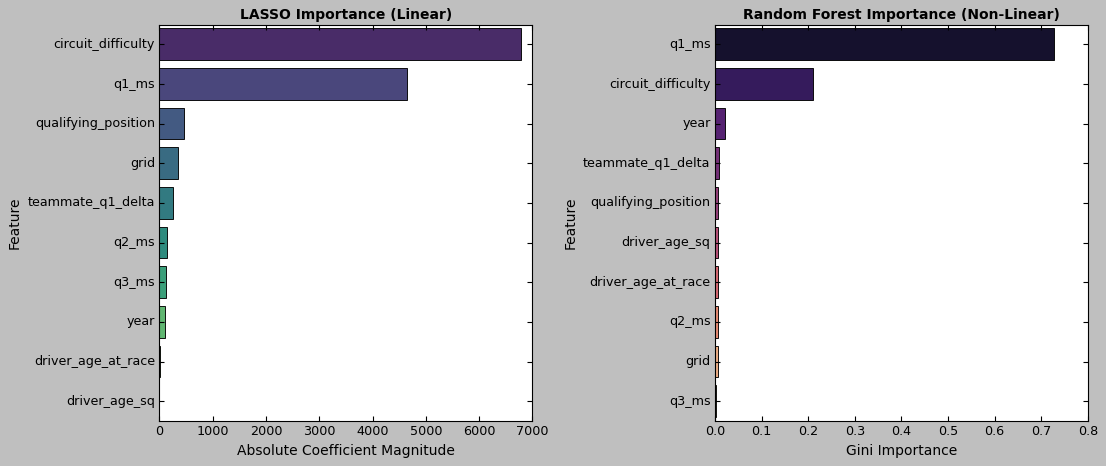

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(data=lasso_importances, x='Lasso_Coef_Abs', y='Feature', ax=ax[0], palette='viridis')
ax[0].set_title('LASSO Importance (Linear)', fontweight='bold')
ax[0].set_xlabel('Absolute Coefficient Magnitude')

sns.barplot(data=rf_importances, x='Importance', y='Feature', ax=ax[1], palette='magma')
ax[1].set_title('Random Forest Importance (Non-Linear)', fontweight='bold')
ax[1].set_xlabel('Gini Importance')
plt.tight_layout()
plt.show()

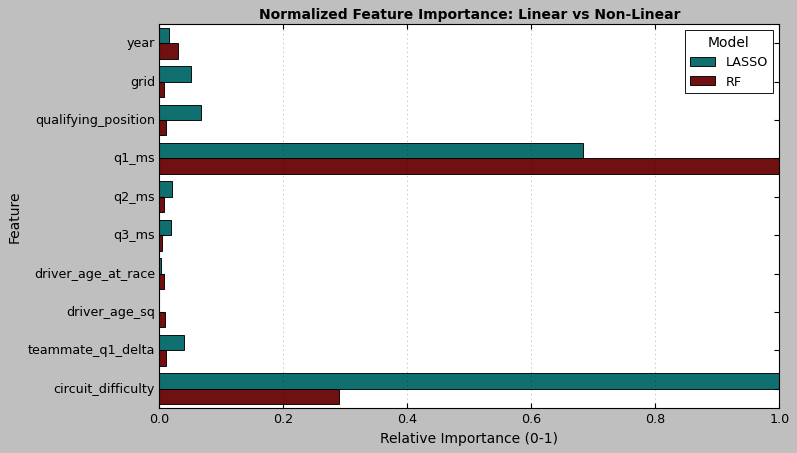

In [ ]:
plt.figure(figsize=(10, 6))

# Combine and sort
importance_data = pd.DataFrame({
    'Feature': X_cols, 
    'LASSO': np.abs(lasso_model.coef_),
    'RF': rf_reg.feature_importances_
}).melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Normalize so they are on same scale (0-1) for visual comparison
importance_data['Importance'] = importance_data.groupby('Model')['Importance'].transform(lambda x: x / x.max())

sns.barplot(data=importance_data, y='Feature', x='Importance', hue='Model', palette=['teal', 'maroon'])
plt.title('Normalized Feature Importance: Linear vs Non-Linear', fontweight='bold')
plt.xlabel('Relative Importance (0-1)')
plt.grid(axis='x', alpha=0.3)
plt.show()

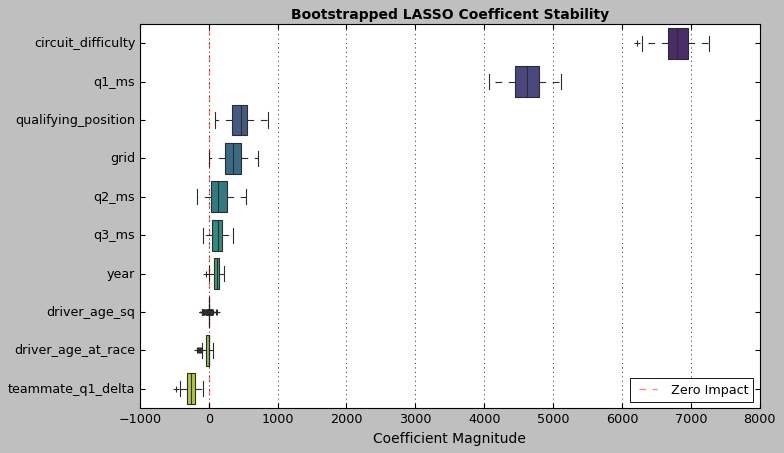

In [ ]:
# Plotting Coefficient Stability
plt.figure(figsize=(10, 6))

# Data Filtration
bs_df = bootstrap_df.copy() # Remove 'q1_ms' otherwise plot gets cluttered
relevant_cols = bs_df.columns[bs_df.abs().mean() > 1]
plot_data = bs_df[relevant_cols]

# Sorted by mean coefficient magnitude
sorted_features = plot_data.mean().sort_values(ascending=False).index

sns.boxplot(data=bs_df[sorted_features], orient='h', palette='viridis')
plt.title("Bootstrapped LASSO Coefficent Stability", fontweight='bold')
plt.xlabel("Coefficient Magnitude")
plt.ylabel("")
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label="Zero Impact") # Subtle zero line
plt.grid(True, axis='x', alpha=0.8)
plt.legend(loc='lower right')
plt.show()

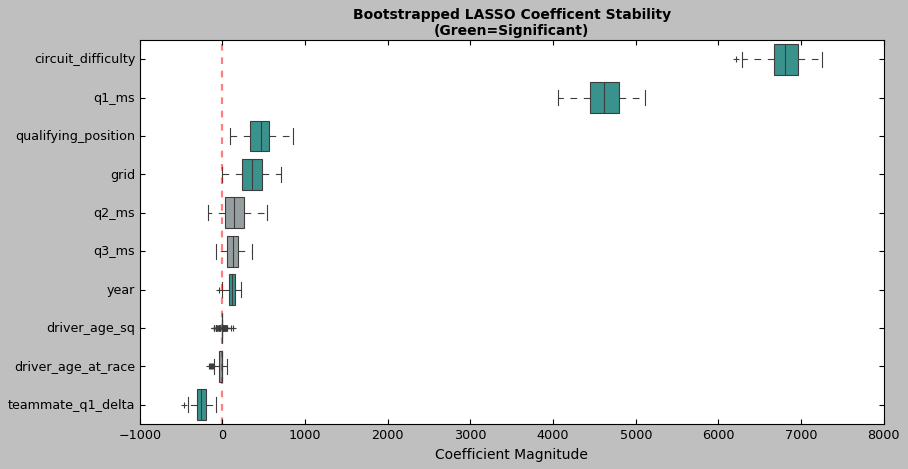

In [ ]:
sorted_feats = coef_summary.sort_values(by='MeanCoef', ascending=False)
plt.figure(figsize=(12, 6))
palette = []
for idx, row in sorted_feats.iterrows():
    if (row['LowerCI'] > 0) or (row['UpperCI'] < 0):
        palette.append("#2aa198") # Teal (Significant)
    else:
        palette.append("#93a1a1") # Grey (Not Significant)
sns.boxplot(data=bs_df[sorted_feats['Feature']], orient='h', palette=palette)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label="Zero Impact")
plt.title("Bootstrapped LASSO Coefficent Stability\n(Green=Significant)", fontweight='bold')
plt.xlabel("Coefficient Magnitude")
plt.show()

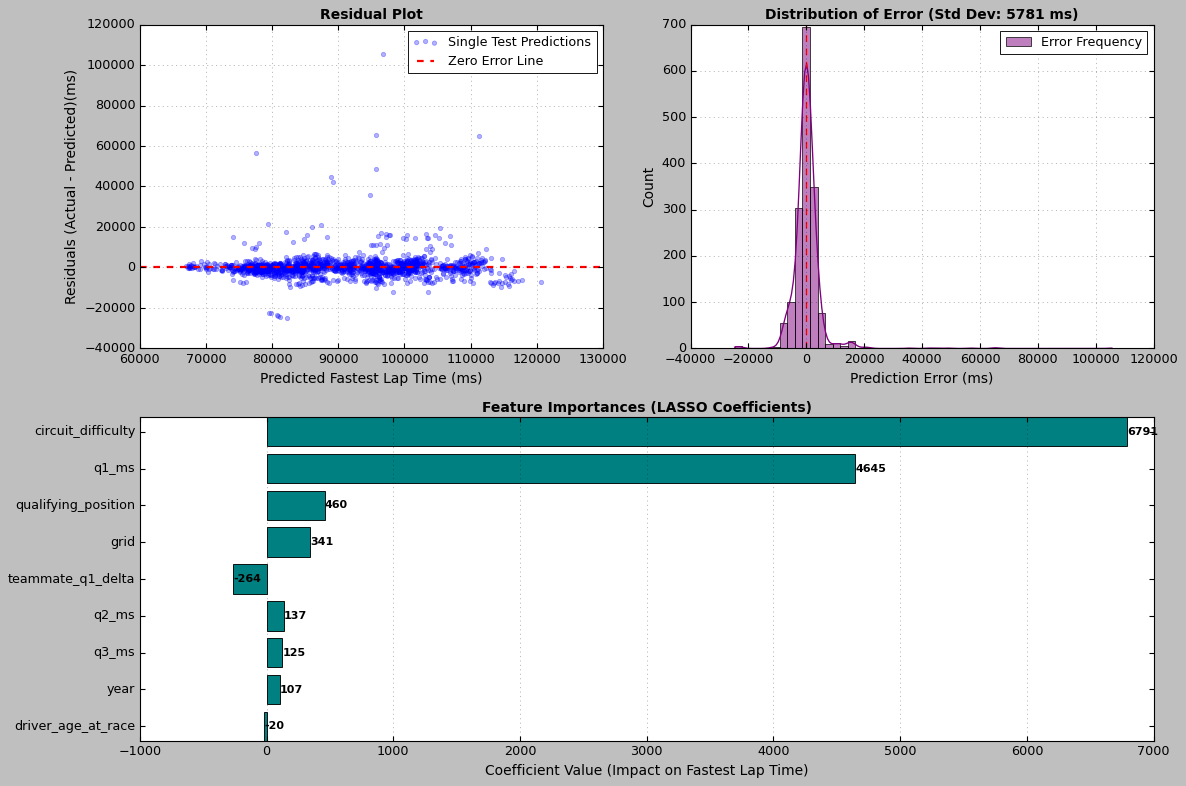

In [ ]:
y1_pred = lasso_model.predict(X_test_scaled)
residuals = y1_test - y1_pred

plt.figure(figsize=(15, 10))

# Setting up subplots
# Residual Plot
plt.subplot(2, 2, 1)
plt.scatter(y1_pred, residuals, alpha=0.3, color='blue', s=15, label='Single Test Predictions')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.xlabel('Predicted Fastest Lap Time (ms)')
plt.ylabel('Residuals (Actual - Predicted)(ms)')
plt.title('Residual Plot', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=50, label='Error Frequency')
plt.xlabel('Prediction Error (ms)')
plt.title(f'Distribution of Error (Std Dev: {np.std(residuals):.0f} ms)', fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)

# LASSO Coefficients (Feature Importance)
nonzero_coefs = coefs[coefs['AbsCoef'] > 0].sort_values(by='AbsCoef', ascending=True)
plt.subplot(2, 1, 2)
bars = plt.barh(nonzero_coefs['Feature'], nonzero_coefs['Coef'], color='teal', label='LASSO Coefficient')
for bar in bars:
    width = bar.get_width()
    plt.text(
        width, 
        bar.get_y() + bar.get_height() / 2,
        f'{int(width)}',
        va='center',
        ha='left',
        fontsize=10,
        color='black',
        fontweight='bold'
    )
plt.title("Feature Importances (LASSO Coefficients)", fontweight='bold')
plt.xlabel('Coefficient Value (Impact on Fastest Lap Time)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

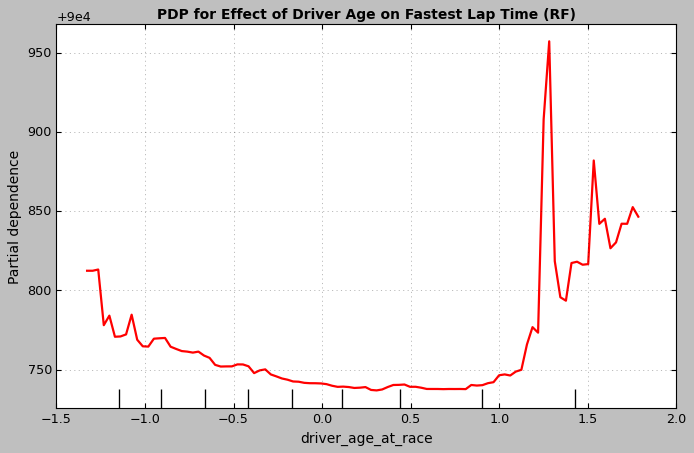

In [ ]:
# Partial Dependence Plot to show non-linearity of 'driver_age_at_race'
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rf_reg,
    X_train_scaled,
    features=[X_cols.index('driver_age_at_race')],
    feature_names=X_cols,
    kind='average',
    ax=ax,
    line_kw={"color": "red", "linewidth": 2}
)
plt.title("PDP for Effect of Driver Age on Fastest Lap Time (RF)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

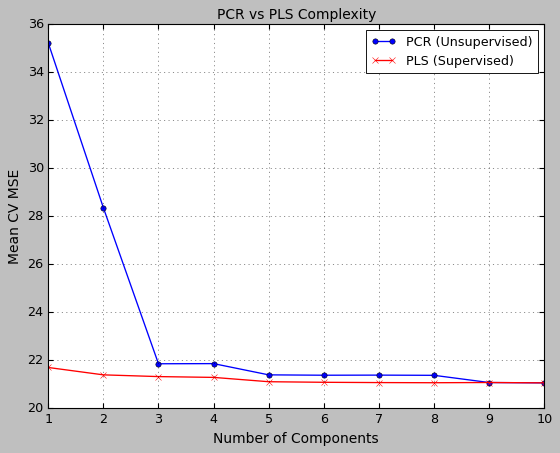

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(n_comp, pcr_mean_mse, marker='o', label='PCR (Unsupervised)', linestyle='-', color='blue')
plt.plot(n_comp, pls_mean_mse, marker='x', label='PLS (Supervised)', linestyle='-', color='red')
plt.xlabel('Number of Components')
plt.ylabel('Mean CV MSE')
plt.title('PCR vs PLS Complexity')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

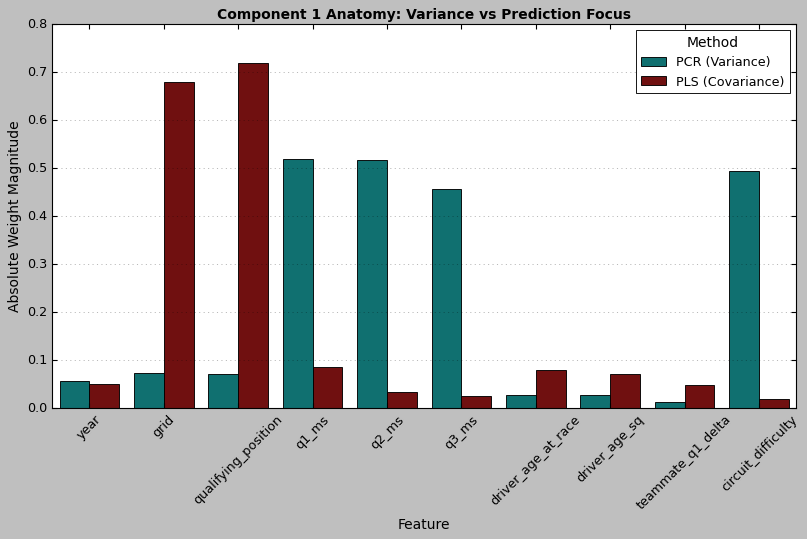

In [ ]:
# Component Weights Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=comp_weights, x='Feature', y='Weight', hue='Method', palette=['teal', 'maroon'])
plt.title("Component 1 Anatomy: Variance vs Prediction Focus", fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("Absolute Weight Magnitude")
plt.grid(axis='y', alpha=0.3)
plt.show()

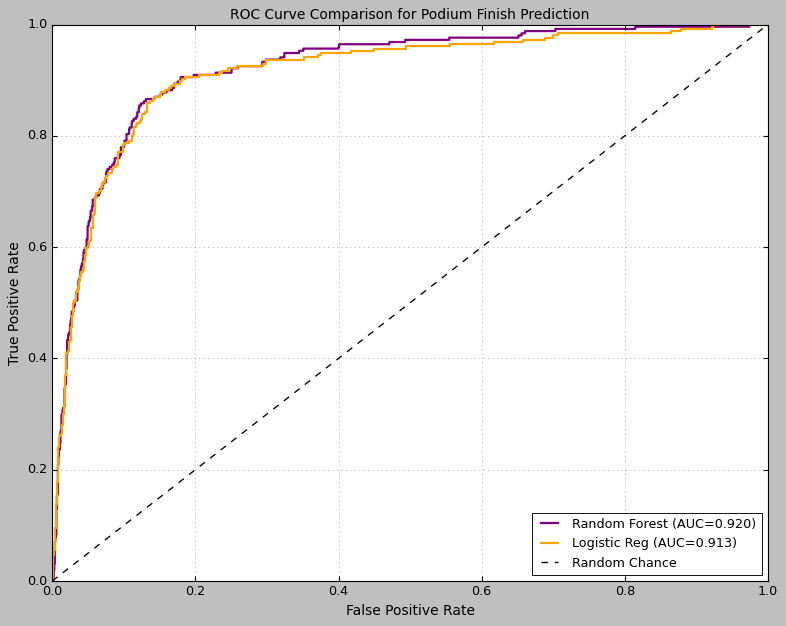

In [ ]:
# ROC Curve for Podium Prediction
y_prob_lr = lr_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y3_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y3_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', color='purple', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={auc_lr:.3f})', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Podium Finish Prediction')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Confusion Matrix at Optimal Threshold

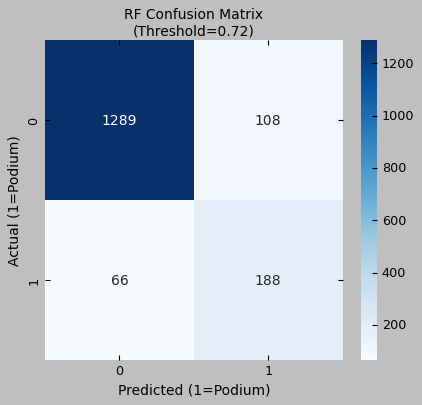

In [ ]:
# RF Confusion Matrix at Optimal Threshold
y_pred_optimal = (y_prob_rf >= best_thresh).astype(int)
cm = confusion_matrix(y3_test, y_pred_optimal)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"RF Confusion Matrix\n(Threshold={best_thresh:.2f})")
plt.xlabel('Predicted (1=Podium)')
plt.ylabel('Actual (1=Podium)')
plt.show()

c:\Users\couga\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\couga\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\couga\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


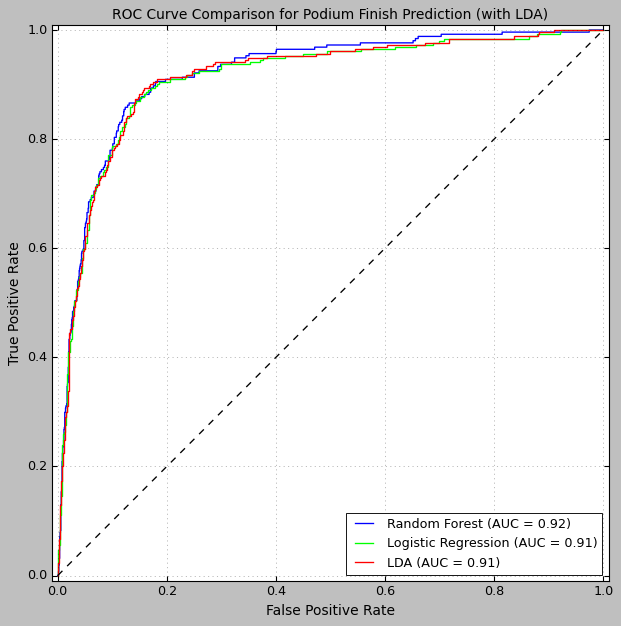

In [ ]:
# ROC Curve with LDA included
plt.figure(figsize=(10,8))
RocCurveDisplay.from_estimator(best_rf_clf, X_test_scaled, y3_test, ax=plt.gca(), color='blue', name='Random Forest')
RocCurveDisplay.from_estimator(lr_clf, X_test_scaled, y3_test, ax=plt.gca(), color='lime', name='Logistic Regression')
RocCurveDisplay.from_estimator(lda, X_test_scaled, y3_test, ax=plt.gca(), color='red', name='LDA')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Podium Finish Prediction (with LDA)')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

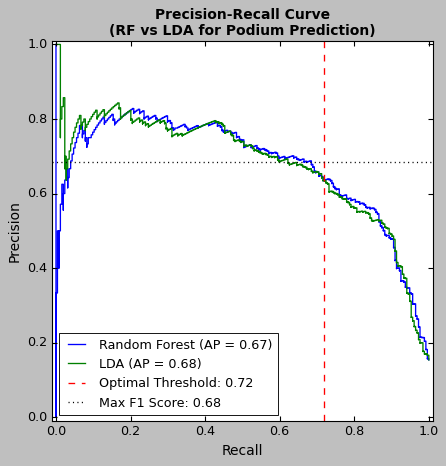

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
PrecisionRecallDisplay.from_estimator(best_rf_clf, X_test_scaled, y3_test, ax=ax, name="Random Forest")
PrecisionRecallDisplay.from_estimator(lda, X_test_scaled, y3_test, ax=ax, name="LDA")
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Optimal Threshold: {best_thresh:.2f}')
plt.axhline(y=best_f1, color='k', linestyle=':', label=f'Max F1 Score: {best_f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title("Precision-Recall Curve\n(RF vs LDA for Podium Prediction)", fontweight='bold')
plt.tight_layout()
plt.show()

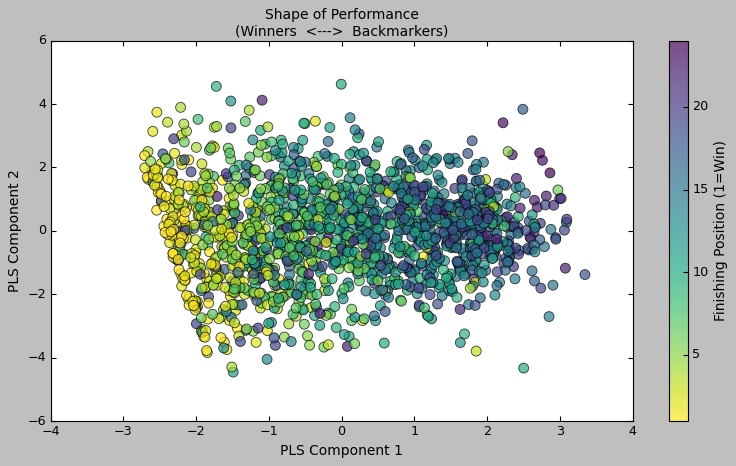

In [ ]:
X_pls_transform = pls_final.transform(X_test_scaled)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pls_transform[:, 0], X_pls_transform[:, 1], 
            c=y2_test, cmap='viridis_r', alpha=0.7, edgecolors='k', s=80)
plt.colorbar(scatter, label='Finishing Position (1=Win)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('Shape of Performance\n(Winners  <--->  Backmarkers)')
plt.tight_layout()
plt.show()